In [9]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
from dotenv import load_dotenv

In [ ]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_BEGIN = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

response_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_BEGIN})
response_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_BEGIN})

In [10]:
#url_visits = 'https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01'
#url_regs = 'https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01'
#response_visits = requests.get(url_visits)
#response_regs = requests.get(url_regs)

if response_visits.status_code == 200:
    visits_json = response_visits.json()
else:
    print(f"Ошибка: {response_visits.status_code}, {response_visits.text}")

if response_regs.status_code == 200:
    regs_json = response_regs.json()
else:
    print(f"Ошибка: {response_regs.status_code}, {response_regs.text}")

visits_df = pd.DataFrame(visits_json)
regs_df = pd.DataFrame(regs_json)
ads_df = pd.read_csv('./ads.csv')

In [11]:
#Создание колонок date_group
visits_df['date_group'] = pd.to_datetime(visits_df['datetime']).dt.date
regs_df['date_group'] = pd.to_datetime(regs_df['datetime']).dt.date

#Исключение визитов, кроме последнего
visits_df = visits_df.sort_values(by='datetime').drop_duplicates(subset='visit_id', keep='last')

#Группировка по дате и платформе
visits_grouped = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')
regs_grouped = regs_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

#Создание объединенного датафрейма для посчета конверсии
conversion_df = pd.merge(visits_grouped, regs_grouped, on=['date_group', 'platform'], how='outer')

#Исключение ботов
conversion_df = conversion_df[conversion_df['platform']!= 'bot'].reset_index(drop=True)

#Заполнение пропусков и приведение числа регистраций к типу int
conversion_df['registrations'] = conversion_df['registrations'].fillna(0).astype(int)

#Расчет конверсий
conversion_df['conversion'] = 100.0 * conversion_df['registrations'] / conversion_df['visits']
conversion_df.head(10)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
5,2023-03-02,web,515,23,4.466019
6,2023-03-03,android,26,22,84.615385
7,2023-03-03,ios,40,34,85.000000
8,2023-03-03,web,617,51,8.265802
9,2023-03-04,android,94,77,81.914894


In [12]:
conversion_json = conversion_df.to_json('./conversion.json')

In [13]:
#Создание колонки date_group
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date

#Группировка по дате и кампании
ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()
print(ads_grouped['utm_campaign'].unique())

#Группировка визитов и регистраций по датам
conversion_grouped = conversion_df.groupby(['date_group'])[['visits', 'registrations']].sum().reset_index()

#Создание объединенного датафрейма
merged_ads = pd.merge(conversion_grouped, ads_grouped, on='date_group', how='left')

#Заполнение пропусков
merged_ads['utm_campaign'] = merged_ads['utm_campaign'].fillna('none')
merged_ads['cost'] = merged_ads['cost'].fillna(0)

['advanced_algorithms_series' 'virtual_reality_workshop'
 'ui_ux_design_drive' 'women_in_tech_symposium' 'intro_to_python_course']


In [14]:
ads_json = merged_ads.to_json('./ads.json')

# Визуализация

## Итоговые визиты

In [15]:
os.makedirs('charts')

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'charts'

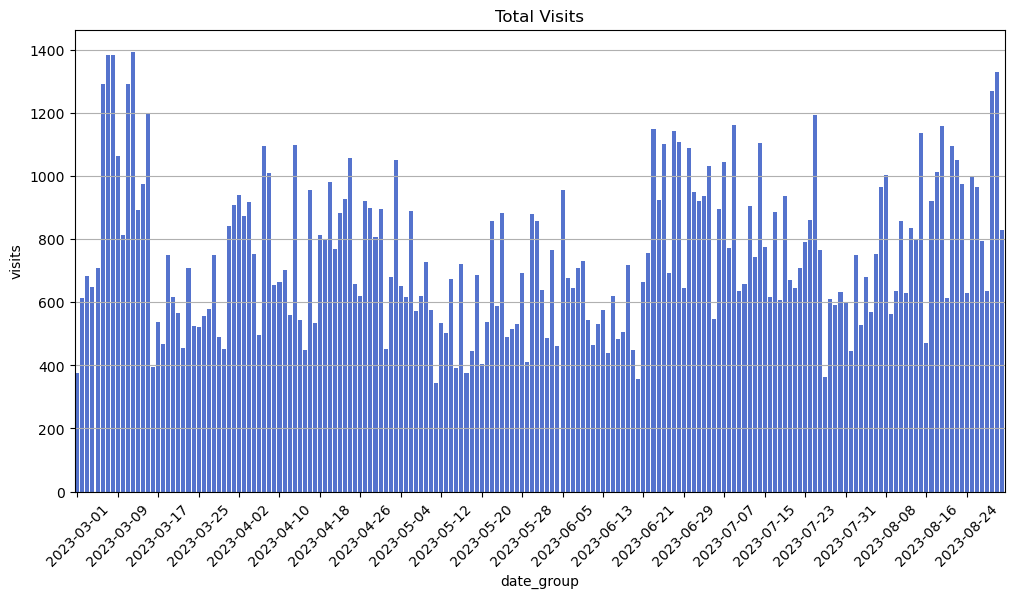

In [16]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=conversion_grouped, x='date_group', y='visits', color='royalblue')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Total Visits')
plt.grid(axis='y')

plt.savefig('./charts/total_visits.png')
plt.show()

## Итоговые визиты с разбивкой по платформам

<Figure size 1200x600 with 0 Axes>

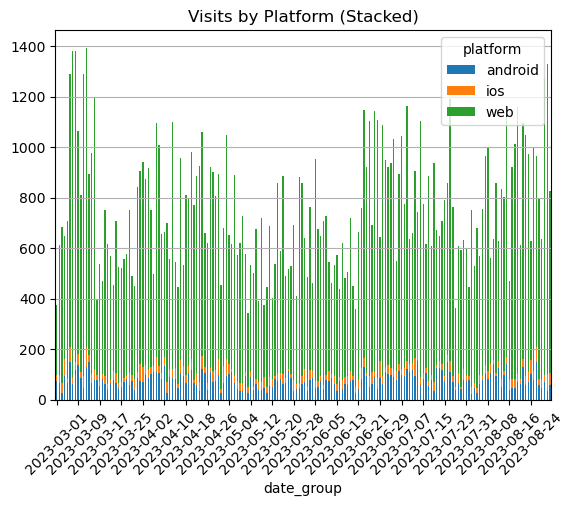

In [17]:
plt.figure(figsize=(12, 6))

visits_df = visits_df[visits_df['platform']!= 'bot']
ax = visits_df.groupby(['date_group','platform']).size().unstack().plot(kind='bar', stacked=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Visits by Platform (Stacked)')
plt.grid(axis='y')
plt.legend(title='platform', loc='upper right')

plt.savefig('./charts/visits_by_platform.png')
plt.show()

## Итоговые регистрации

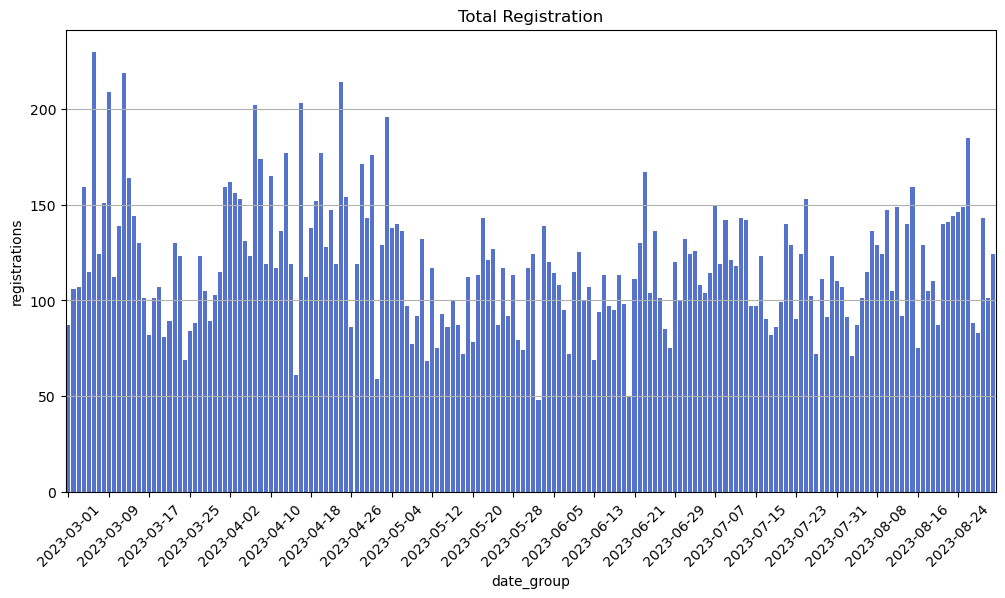

In [18]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=conversion_grouped, x='date_group', y='registrations', color='royalblue')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Total Registration')
plt.grid(axis='y')

plt.savefig('./charts/total_regs.png')
plt.show()

## Итоговые регистрации с разбивкой по платформам

<Figure size 1200x600 with 0 Axes>

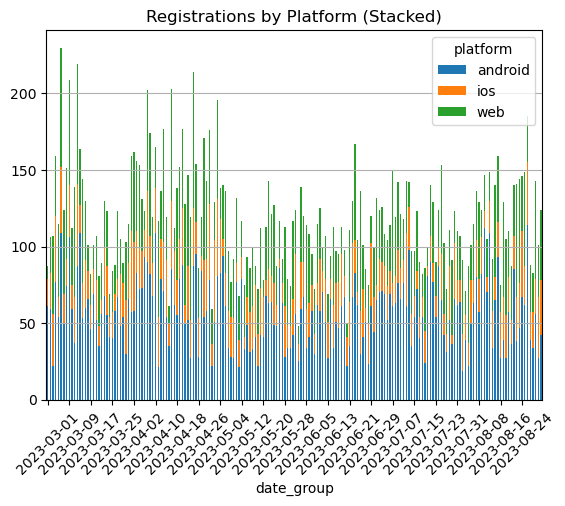

In [19]:
plt.figure(figsize=(12, 6))

regs_df = regs_df[regs_df['platform']!= 'bot']
ax = regs_df.groupby(['date_group','platform']).size().unstack().plot(kind='bar', stacked=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Registrations by Platform (Stacked)')
plt.grid(axis='y')
plt.legend(title='platform', loc='upper right')

plt.savefig('./charts/regs_by_platform.png')
#plt.show()

## Средняя конверсия

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


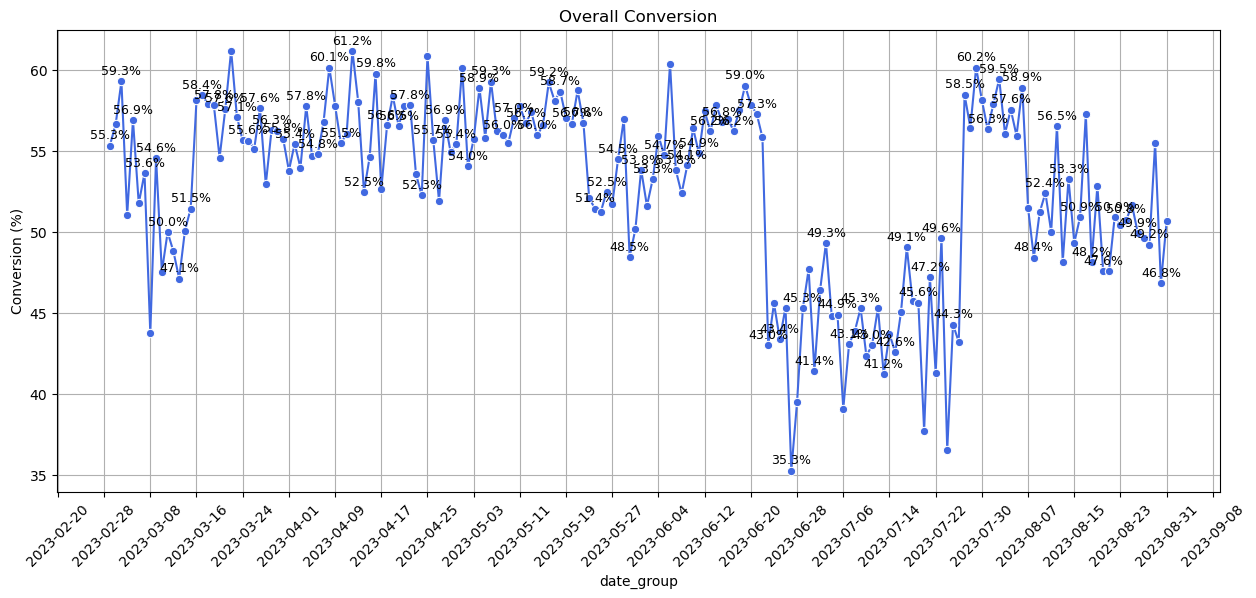

In [20]:
plt.figure(figsize=(15, 6))

conversion_grouped2 = conversion_df.groupby(['date_group'])[['conversion']].mean().reset_index()
ax = sns.lineplot(data=conversion_grouped2, x='date_group', y='conversion', color='royalblue', marker='o')

for i, (x, y) in enumerate(zip(conversion_grouped2['date_group'], conversion_grouped2['conversion'])):
    if i % 2 == 0:
        ax.annotate(
            f'{y:.1f}%',
            (x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha='center',
            fontsize=9
        )

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Overall Conversion')
plt.ylabel('Conversion (%)')
plt.grid()

plt.savefig('./charts/overall_conversion.png')
plt.show()

## Конверсия по каждой платформе

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


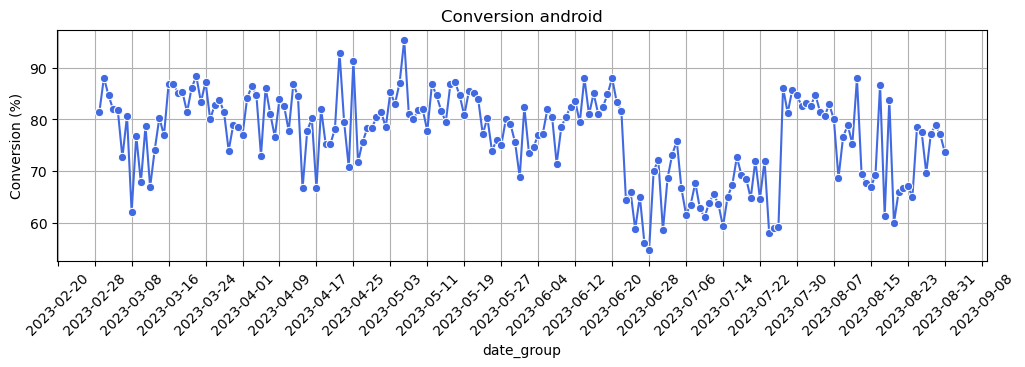

In [21]:
plt.figure(figsize=(12, 3))

conversion_android = conversion_df[conversion_df['platform'] == 'android']
ax = sns.lineplot(data=conversion_android, x='date_group', y='conversion', color='royalblue', marker='o')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Conversion android')
plt.ylabel('Conversion (%)')
plt.grid()

plt.savefig('./charts/conversion_android.png')
plt.show()

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


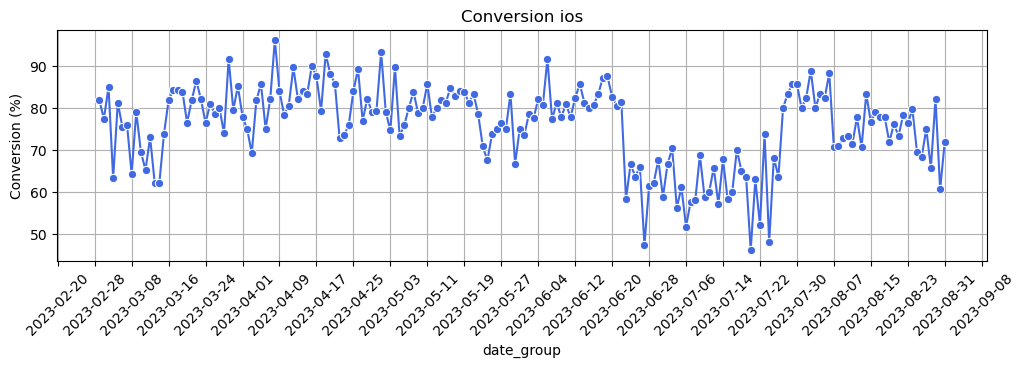

In [22]:
plt.figure(figsize=(12, 3))

conversion_ios = conversion_df[conversion_df['platform'] == 'ios']
ax = sns.lineplot(data=conversion_ios, x='date_group', y='conversion', color='royalblue', marker='o')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Conversion ios')
plt.ylabel('Conversion (%)')
plt.grid()

plt.savefig('./charts/conversion_ios.png')
plt.show()

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


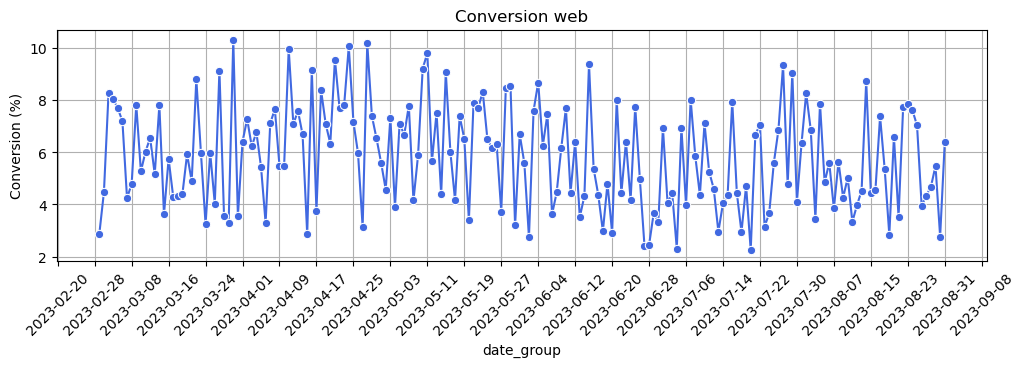

In [23]:
plt.figure(figsize=(12, 3))

conversion_web = conversion_df[conversion_df['platform'] == 'web']
ax = sns.lineplot(data=conversion_web, x='date_group', y='conversion', color='royalblue', marker='o')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Conversion web')
plt.ylabel('Conversion (%)')
plt.grid()

plt.savefig('./charts/conversion_web.png')
plt.show()

## Стоимости реклам

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


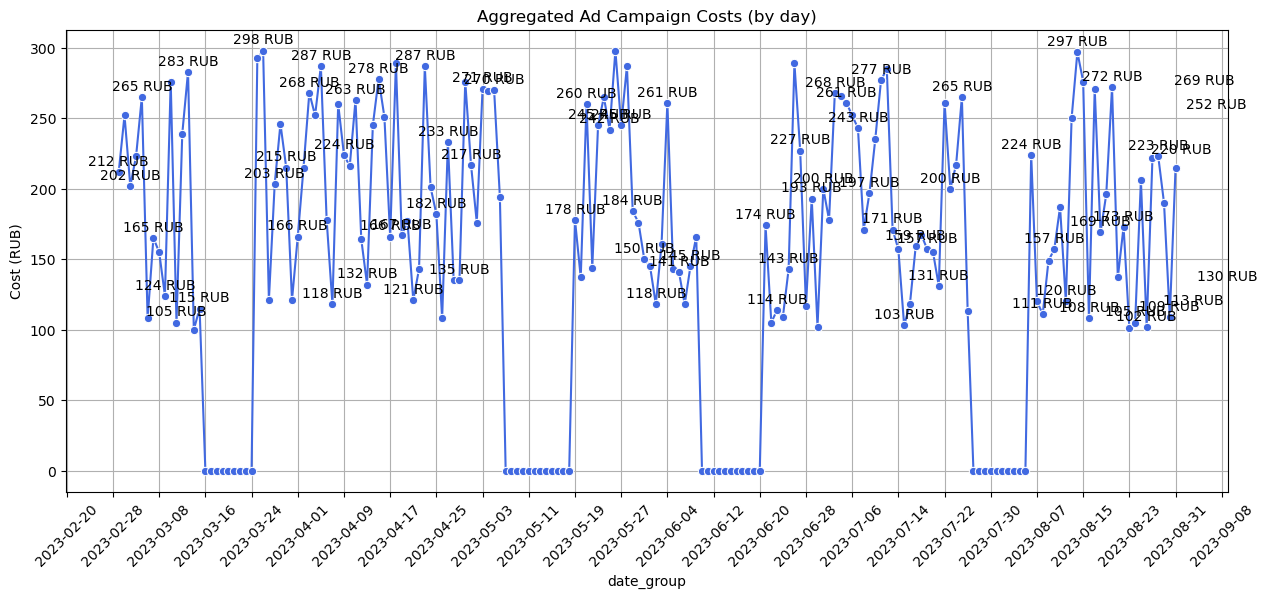

In [24]:
plt.figure(figsize=(15, 6))

ads_grouped2 = ads_df.groupby(['date_group'])['cost'].sum().reset_index()
ads_for_vis = pd.merge(conversion_grouped, ads_grouped2, on=['date_group'], how='left')
ads_for_vis['cost'] = ads_for_vis['cost'].fillna(0)

ax = sns.lineplot(data=ads_for_vis, x='date_group', y='cost', color='royalblue', marker='o')

for i, (x, y) in enumerate(zip(ads_grouped2['date_group'], ads_grouped2['cost'])):
    if i % 2 == 0:
        ax.annotate(
            f'{y:.0f} RUB',
            (x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha='center'
        )

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.ylabel('Cost (RUB)')
plt.grid()

plt.savefig('./charts/ads_cost.png')
plt.show()

## Визиты и регистрации с выделением рекламных кампаний

In [25]:
ads_campaigns = ads_df.groupby('utm_campaign')['date'].agg(start_date='min', end_date='max').reset_index()
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightpink', 'lightsalmon']

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


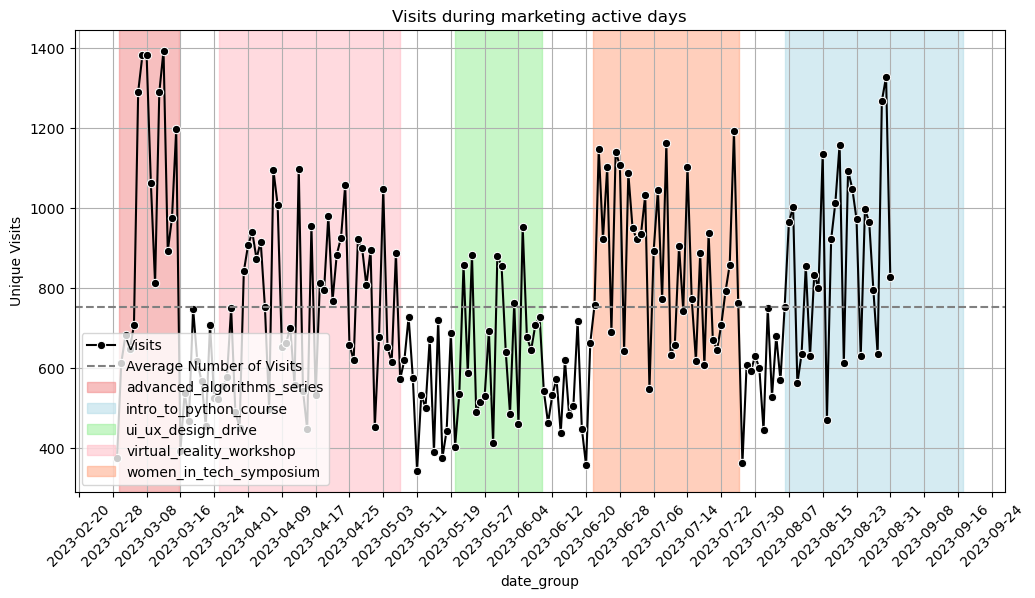

In [26]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=conversion_grouped, x='date_group', y='visits', color='black', marker='o', label='Visits')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Visits during marketing active days')
plt.ylabel('Unique Visits')
plt.grid()

mean_visits = conversion_grouped['visits'].mean()
ax.axhline(mean_visits, linestyle='dashed', color='grey', label='Average Number of Visits')

campaign_labels = []

for i, row in ads_campaigns.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    campaign_name = row['utm_campaign']
    color = colors[i % len(colors)]
    ax.axvspan(start_date, end_date, color=color, alpha=0.5, label=campaign_name)

    if campaign_name not in campaign_labels:
        campaign_labels.append((campaign_name, color))

ax.legend(loc='lower left')
plt.savefig('./charts/visits_with_marketing.png')

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


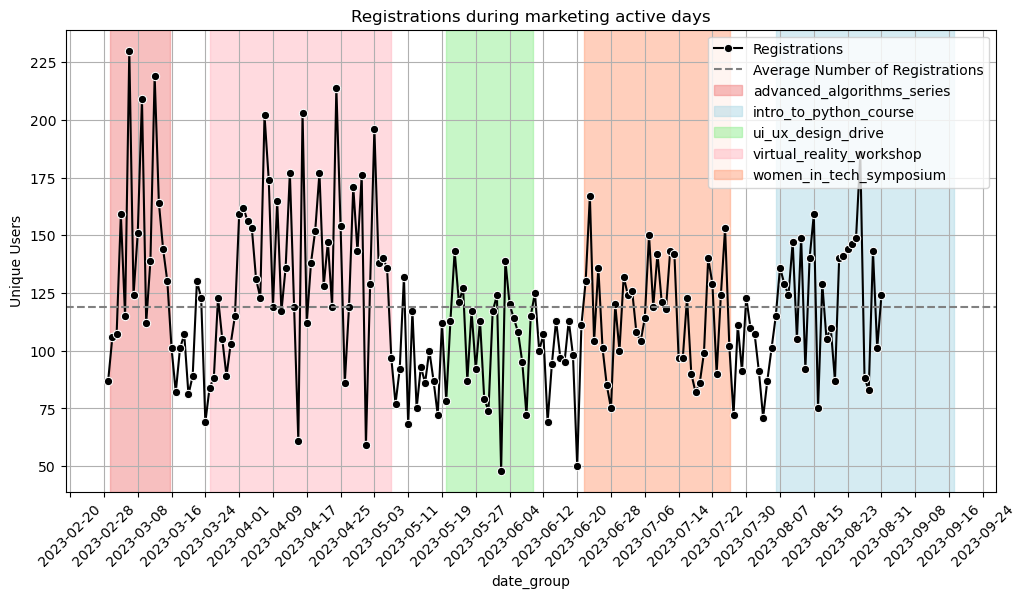

In [27]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=conversion_grouped, x='date_group', y='registrations', color='black', marker='o', label='Registrations')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.title('Registrations during marketing active days')
plt.ylabel('Unique Users')
plt.grid()

mean_regs = conversion_grouped['registrations'].mean()
ax.axhline(mean_regs, linestyle='dashed', color='grey', label='Average Number of Registrations')

campaign_labels = []

for i, row in ads_campaigns.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    campaign_name = row['utm_campaign']
    color = colors[i % len(colors)]
    ax.axvspan(start_date, end_date, color=color, alpha=0.5, label=campaign_name)

    if campaign_name not in campaign_labels:
        campaign_labels.append((campaign_name, color))

ax.legend(loc='upper right')
plt.savefig('./charts/registrations_with_marketing.png')